In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import csv
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

data = pd.read_excel("./Online Retail.xlsx")

In [326]:
'''
Collecting and Cleaning Data 
'''
data=data.drop_duplicates(subset=['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']) #renove the duplicated data rows.

#converting colunn types.
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'], errors='coerce')
data['Quantity']=data['Quantity'].astype('float')
data['UnitPrice']=data['UnitPrice'].astype('float')
data['CustomerID']=data['CustomerID'].astype('object')

#remove outliers.
data[data["Quantity"] < 0] = np.nan
data[data["UnitPrice"] < 0] = np.nan
data = data.dropna()

#checking cancelled orders.
for i in list(np.unique(data['InvoiceNo'].values)):
    if "C" in str(i) or "c" in str(i):
        print("cancellation found")
print("Not found cancellation!")



Not found cancellation!


In [384]:
'''
Calcuation three parameters values.
'''
data["Amount"] = data["Quantity"]*data["UnitPrice"]
Last_date=data.InvoiceDate.max()+datetime.timedelta(days=1)


Recent_purchase = data.groupby(['CustomerID']).InvoiceDate.apply(lambda x:(Last_date-x.max()).days)
Freq_purchase=data.groupby(['CustomerID']).InvoiceNo.count()
Money_purchase=data.groupby(['CustomerID']).Amount.sum()
df1 = Recent_purchase.to_frame()
df2 = Freq_purchase.to_frame()
df3 = Money_purchase.to_frame()

#merge all three parameters into a new dataframe.
newData = pd.merge(df1, df2, left_index=True, right_index=True)
newData = pd.merge(newData, df3, left_index=True, right_index=True)
newData.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Amount':'Monetary'},inplace=True)

In [405]:
'''
This function is going to assign 1 to 5 for R,F,M values of each unique customer.
'''
def rankingFive(col, newcol, reverse): #reverse means that the smaller value has the higher rank.
    vals = list(newData[col])
    vals.sort()
    clas = len(vals)//5
    b1, b2, b3, b4 = vals[0+clas], vals[0+2*clas], vals[0+3*clas], vals[0+4*clas]
    Min = newData[col].min()
    Max = newData[col].max()
    if reverse == False:
        for index, row in tqdm(newData.iterrows()):
            if Min <= row[col] <= b1:
                newData.loc[index, newcol] = 1
            elif b1 <= row[col] <= b2:
                newData.loc[index, newcol] = 2
            elif b2 <= row[col] <= b3:
                newData.loc[index, newcol] = 3
            elif b3 <= row[col] <= b4:
                newData.loc[index, newcol] = 4
            else:
                newData.loc[index, newcol] = 5
    else:
        for index, row in tqdm(newData.iterrows()):
            if Min <= row[col] <= b1:
                newData.loc[index, newcol] = 5
            elif b1 <= row[col] <= b2:
                newData.loc[index, newcol] = 4
            elif b2 <= row[col] <= b3:
                newData.loc[index, newcol] = 3
            elif b3 <= row[col] <= b4:
                newData.loc[index, newcol] = 2
            else:
                newData.loc[index, newcol] = 1

rankingFive("Recency", "R-score", True)
rankingFive("Frequency", "F-score", False)
rankingFive("Monetary", "M-score", False)

#merge RFM and calculate the RFM values by average of three values.
for index, row in tqdm(newData.iterrows()):
    newData.loc[index, "RFM"] = str(int(row["R-score"]))+str(int(row["F-score"]))+str(int(row["M-score"]))
    newData.loc[index, "RFM_score"] = round((int(row["R-score"])+int(row["F-score"])+int(row["M-score"]))/3, 0) #round to integer.
newData=newData.drop(['M-score','R-score','F-score'], axis=1)

4339it [00:00, 8841.12it/s]
4339it [00:00, 8769.76it/s]
4339it [00:00, 8747.85it/s]
4339it [00:00, 5093.02it/s]


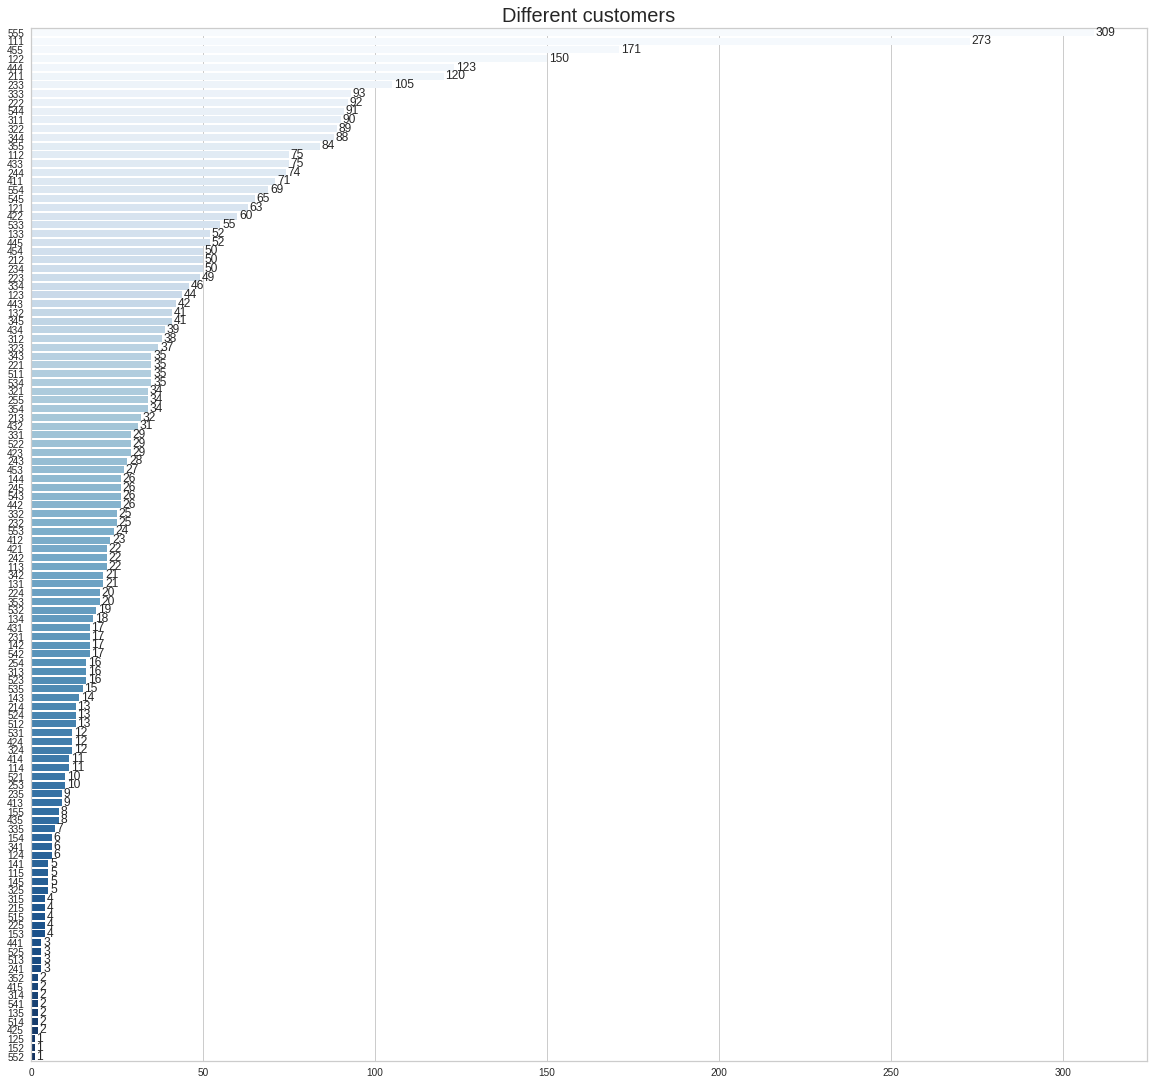

In [406]:
plt.figure(1,figsize=(20,19))
sns.countplot(y="RFM",order=newData['RFM'].value_counts().index ,data=newData,palette='Blues')
plt.title('Different customers',fontsize=20)
plt.xlabel('')
plt.ylabel('')

con=list(newData.groupby('RFM').RFM.count().values)
con=sorted(con,reverse=True)

for x,y in enumerate(con):
    plt.text(y+0.5,x,'%s' %y,va='center',size=12)
plt.show()


In [407]:
newData.groupby('RFM_score').sum()

,Recency,Frequency,Monetary
RFM_score,,,
1.0,128380,4830,89443.800
2.0,155109,23643,596488.842
3.0,77504,51245,928566.041
4.0,34042,107408,2221066.371
5.0,6402,205606,5051643.840


In [408]:
newData.describe()

,Recency,Frequency,Monetary,RFM_score
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,92.518322,90.512100,2048.215924,3.003227
std,100.009747,225.515328,8984.248352,1.242957
min,1.000000,1.000000,0.000000,1.000000
25%,18.000000,17.000000,306.455000,2.000000
50%,51.000000,41.000000,668.560000,3.000000
75%,142.000000,98.000000,1660.315000,4.000000
max,374.000000,7676.000000,280206.020000,5.000000


In [409]:
#use the log transform and standard scaler to normalize the data.
RFMtable=newData[['Recency','Frequency','Monetary']].round(3)
clusterData=newData[['Recency','Frequency','Monetary']].apply(np.log1p,axis=1)
for i in ["Frequency", "Recency", "Monetary"]: #standard scaler.
        clusterData[i] = StandardScaler().fit_transform(clusterData[[i]].values)

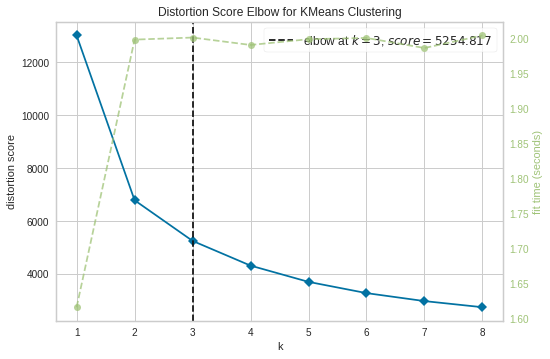

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [410]:
# calculate the elbow point.
clusters = KMeans()
visualizer = KElbowVisualizer(clusters, k=(1,9))

visualizer.fit(clusterData)
visualizer.show()

In [411]:
# Elbow point = 3, so there are three clusters.
clusters = KMeans(n_clusters=3,random_state=1)  # 3 clusters
clusters.fit(clusterData) #start clustering.
RFMtable["Label"] = clusters.labels_ #assign labels to each custormer.

In [412]:
data_0 = newData[RFMtable["Label"] == 0]
data_1 = newData[RFMtable["Label"] == 1]
data_2 = newData[RFMtable["Label"] == 2]

In [413]:
data_2.mean()

Recency        65.136785
Frequency      63.185286
Monetary     1149.077222
RFM                  inf
RFM_score       3.258856
dtype: float64

In [414]:
data_1.mean()

Recency        14.324716
Frequency     261.716649
Monetary     6534.435677
RFM                  inf
RFM_score       4.634953
dtype: float64

In [415]:
data_0.mean()

Recency      174.404034
Frequency     15.424203
Monetary     299.188608
RFM                 inf
RFM_score      1.671438
dtype: float64

In [416]:
newData

,Recency,Frequency,Monetary,RFM,RFM_score
CustomerID,,,,,
12346.0,326,1,77183.60,115,2.0
12347.0,2,182,4310.00,555,5.0
12348.0,75,31,1797.24,234,3.0
12349.0,19,73,1757.55,444,4.0
12350.0,310,17,334.40,122,2.0
...,...,...,...,...,...
18280.0,278,10,180.60,111,1.0
18281.0,181,7,80.82,111,1.0
18282.0,8,12,178.05,511,2.0


In [417]:
#generate the mean, std, cov, max, min for R, F, M based on RFM values.
def cov(x):
    return np.std(x)/np.mean(x)
 
newData.groupby('RFM_score').agg({'Recency':['mean','std',cov, 'max', 'min'],'Frequency':['mean','std',cov, 'max', 'min'],'Monetary':['mean','std',cov, 'max', 'min']}).round(1)

Recency                      Frequency                        \
             mean    std  cov  max min      mean    std  cov   max min   
RFM_score                                                                
1.0         241.8   84.0  0.3  374  73       9.1    6.1  0.7    29   1   
2.0         136.4  102.1  0.7  374   1      20.8   14.2  0.7    96   1   
3.0          72.3   64.8  0.9  366   1      47.8   28.8  0.6   232   2   
4.0          34.6   36.9  1.1  372   1     109.0   72.5  0.7   656   1   
5.0          10.4    8.8  0.8   33   1     334.9  520.9  1.6  7676  59   

          Monetary                                 
              mean      std  cov       max    min  
RFM_score                                          
1.0          168.4     84.5  0.5     464.0    3.8  
2.0          524.6   2889.4  5.5   77183.6    0.0  
3.0          866.2    802.3  0.9    9864.3  108.8  
4.0         2254.9   6359.6  2.8  168472.5  251.0  
5.0         8227.4  21013.2  2.6  280206.0  954.4

In [418]:
#generate the mean, std, cov, max, min for R, F, M based on labels.
RFMtable.groupby('Label').agg({'Recency':['mean','std',cov, 'max', 'min'],'Frequency':['mean','std',cov, 'max', 'min'],'Monetary':['mean','std',cov, 'max', 'min']}).round(1)

Recency                      Frequency                       Monetary  \
         mean    std  cov  max min      mean    std  cov   max min     mean   
Label                                                                         
0       174.4  108.9  0.6  374   2      15.4   11.8  0.8    81   1    299.2   
1        14.3   14.9  1.0  100   1     261.7  429.6  1.6  7676   3   6534.4   
2        65.1   63.4  1.0  372   1      63.2   44.9  0.7   521   1   1149.1   

                                      
           std  cov       max    min  
Label                                 
0        273.3  0.9    4055.7    0.0  
1      18022.1  2.8  280206.0  454.5  
2       2407.9  2.1   77183.6  120.0